# Лаборотораня работа №4

# Нейросети в задачих обработки текстов. Генерация коротких текстов с помощью Transformer

### Ласточкин Иван

Цель работы: изучить возможность генерации текстов с помощью нейросетей.

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
import os
start_token = "_"
eos = '#'

with open("names.txt") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print(f'There are {len(names)} names: ')
for x in names[::1000]:
    print(x)

There are 7578 names: 
_Stephana#
_Korry#
_Veradis#
_Teddie#
_Dorena#
_Mimi#
_Stevana#
_Lonna#


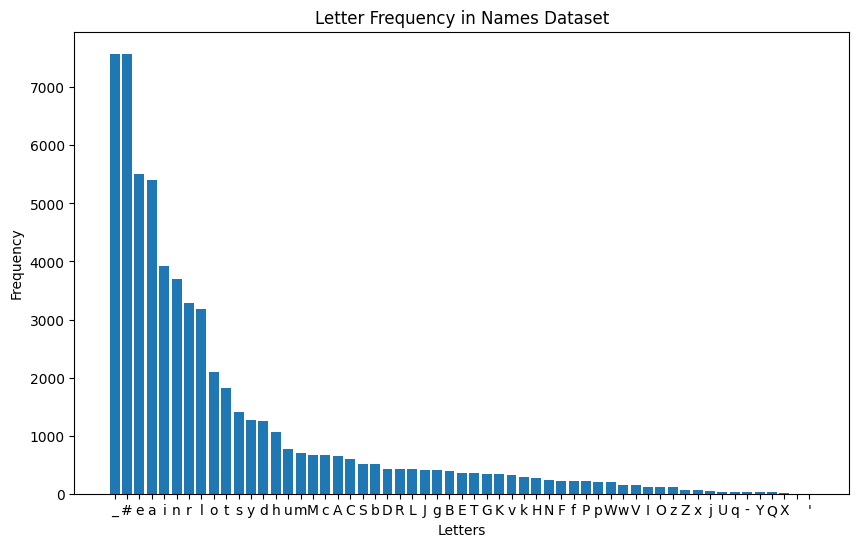

max length = 17
There are 59 tokens
Vocabulary: _# #'-ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz
_Stephana#
_Nicholas#
_Ellynn#
_Colly#
_Braden#
_Aile#
_Glyn#
_Teddi#
_Jere#
_Elyn#
[[ 0 24 52 37 48 40 33 46 33  3]
 [ 0 19 41 35 40 47 44 33 51  3]
 [ 0 10 44 44 57 46 46  3  2  2]
 [ 0  8 47 44 44 57  3  2  2  2]
 [ 0  7 50 33 36 37 46  3  2  2]
 [ 0  6 41 44 37  3  2  2  2  2]
 [ 0 12 44 57 46  3  2  2  2  2]
 [ 0 25 37 36 36 41  3  2  2  2]
 [ 0 15 37 50 37  3  2  2  2  2]
 [ 0 10 44 57 46  3  2  2  2  2]]


(6062, 1516)

In [3]:
# TODO: постройте частоты употреблений букв
from collections import Counter

letters = [char for name in names for char in name]
letter_counts = Counter(letters)
sorted_letters = sorted(letter_counts.items(), key=lambda x: x[1], reverse=True)
letters, counts = zip(*sorted_letters)

plt.figure(figsize=(10, 6))
plt.bar(letters, counts)
plt.xlabel('Letters')
plt.ylabel('Frequency')
plt.title('Letter Frequency in Names Dataset')
plt.show()

# определите максимальную длину последовательности
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

# отберите уникальные токены и заполните словари для конвертации токенов <-> индексы
tokens = ['_', '#'] + sorted(set(''.join(names)))
tok2id = {token: idx for idx, token in enumerate(tokens)}
id2tok = {idx: token for token, idx in tok2id.items()}

n_tokens = len(tokens)
print(f'There are {n_tokens} tokens')

# проверка, что start_token имеет номер 0
if tok2id.get('_') != 0:
    tok2id['_'] = 0
    id2tok[0] = '_'

print('Vocabulary:', "".join(tokens))

# функция для преобразования списка имен в матрицу
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

# разбейте все имена на тренировочную (80%) и тестовую часть (20%)
def split_data(names, train_ratio=0.8):
    random.shuffle(names)
    split_idx = int(len(names) * train_ratio)
    return names[:split_idx], names[split_idx:]

train_data, val_data = split_data(names)

len(train_data), len(val_data)


## Char-Transformer для имен

In [4]:
import torch.nn as nn
import torch
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

# Определение класса NameTransformer
class NameTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=2, n_head=2, dropout=0.1):
        super(NameTransformer, self).__init__()
        self.vocab_size = vocab_size
        
        # Создание слоя Embedding для символов
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        # Создание маски позиций
        self.position_ids = torch.arange(MAX_LENGTH).unsqueeze(1)

        # Создание слоя TransformerEncoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(emb_size, n_head, hidden_size, dropout, batch_first=True),
            n_layers
        )

        # Создание линейного слоя для преобразования выхода Transformer в логиты
        self.linear = nn.Linear(emb_size, vocab_size)

    def _generate_square_subsequent_mask(self, seq_len):
        mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, input):
        # Преобразование символов в Embedding
        x = self.embedding(input)
        
        # Добавление маски позиций
        x = x + self.position_ids[:x.size(1), :].unsqueeze(0)
        
        # Создание маски для предотвращения "заглядывания в будущее"
        seq_len = x.size(1)
        mask = self._generate_square_subsequent_mask(seq_len).to(x.device)

        # Пропуск через TransformerEncoder
        x = self.transformer_encoder(x, mask=mask)

        # Преобразование выхода в логиты
        output = self.linear(x)

        return output


## Тренировка

In [5]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        nums = to_matrix(batch)
        
        # преобразование в тензоры PyTorch
        input_seq = torch.tensor(nums[:, :-1], dtype=torch.long)
        target_seq = torch.tensor(nums[:, 1:], dtype=torch.long)
        
        optimizer.zero_grad()
        output = model(input_seq)
        
        # вычисление потерь
        loss = F.cross_entropy(output.permute(0, 2, 1), target_seq, ignore_index=tok2id[' '])
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
    
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    
    with torch.no_grad():
        for batch in test_batches:  
            nums = to_matrix(batch)
            
            input_seq = torch.tensor(nums[:, :-1], dtype=torch.long)
            target_seq = torch.tensor(nums[:, 1:], dtype=torch.long)
            
            output = model(input_seq)
            loss = F.cross_entropy(output.permute(0, 2, 1), target_seq, ignore_index=tok2id[' '])
            
            loss_log.append(loss.item())
    
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        val_log.append((total_steps, np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)


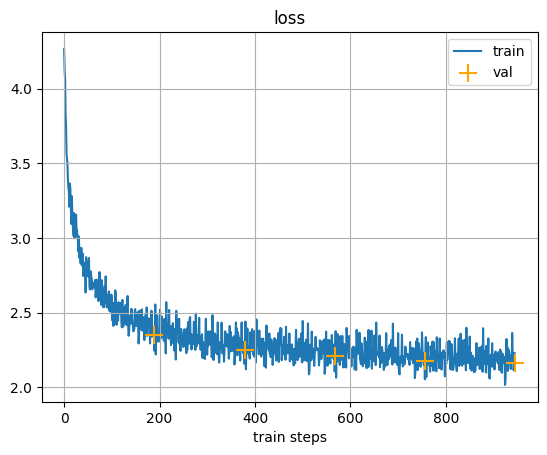

In [6]:
model = NameTransformer(len(tokens), 64, 64, n_layers=2, n_head=2, dropout=0.1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, 5)

## Генерация по argmax

In [7]:
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
    return torch.argmax(logits, dim=-1)

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix="_"):
    nums = to_matrix([prefix])
    nums = torch.from_numpy(nums).long()
    
    prefix_tensor = nums[0].unsqueeze(0)
    prefix_output = model(prefix_tensor)
    next_token = pick_by_argmax(prefix_output[0, -1, :]).item()

    continuation = [next_token]
    for _ in range(10):  # Генерируем 10 символов
        continuation_tensor = torch.tensor([continuation])
        continuation_output = model(continuation_tensor)
        next_token = pick_by_argmax(continuation_output[0, -1, :]).item()
        continuation.append(next_token)

    print(prefix + '|' + ids2string(continuation))

# Пример использования
gen_continuation(model, " Ku")


 Ku|sielle#####


## Генерация с семплированием

In [8]:
# Напишите функцию генерации батчами с семплированием из распределения и температурой
def batch2string(ids, prefix):
    return [prefix + "".join(id2tok[_] for _ in batch) for batch in ids]


def pick_by_distribution(logits, temperature=1.0):
    probs = F.softmax(logits / temperature, dim=-1)
    sampled_ids = torch.multinomial(probs, 1)
    return sampled_ids


def gen_continuation_temp(model, prefix="_", temperature=1.0, n=10):
    nums = to_matrix([prefix] * n)
    nums = torch.from_numpy(nums).long()

    prefix_tensor = nums[0].unsqueeze(0)
    prefix_output = model(prefix_tensor)
    next_token = pick_by_distribution(prefix_output[0, -1, :], temperature=temperature)

    continuation = [next_token]
    for _ in range(10):  # Генерируем 10 символов
        continuation_tensor = torch.cat([prefix_tensor, torch.tensor(continuation).unsqueeze(0)], dim=1)
        continuation_output = model(continuation_tensor)
        next_token = pick_by_distribution(continuation_output[0, -1, :], temperature=temperature)
        continuation.append(next_token)

    print(batch2string(torch.cat([torch.tensor(continuation).unsqueeze(0)], dim=1).tolist(), prefix + '|'))

# Пример использования
gen_continuation_temp(model, prefix=" An", temperature=0.5, n=10)


[' An|gele#######']
